In [10]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/150.0 MB 3.1 MB/s eta 0:00:48
   ---------------------------------------- 1.8/150.0 MB 3.4 MB/s eta 0:00:45
    --------------------------------------- 2.6/150.0 MB 3.5 MB/s eta 0:00:42
    --------------------------------------- 3.7/150.0 MB 3.8 MB/s eta 0:00:39
   - -------------------------------------- 5.0/150.0 MB 4.2 MB/s eta 0:00:35
   - -------------------------------------- 6.6/150.0 MB 4.6 MB/s eta 0:00:32
   -- ------------------------------------- 8.4/150.0 MB 5.1 MB/s eta 0:00:28
   -- ------------------------------------- 9.7/150.0 MB 5.3 MB/s eta 0:00:27
   --- ------------------------------------ 11.3/150.0 MB 5.6 MB/s eta 0:00:25
   --- ------------------------------------ 13.1/150.0 MB 5.8 MB/s eta 0:00:24
   --- ------------------------------------ 14.9/150.0 MB 6.1 MB/s eta 0:00:


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

In [4]:
data_path = "data/customer_return_risk_dataset.csv"
df = pd.read_csv(data_path)
print("\nDataset Shape:", df.shape)
df.head()


Dataset Shape: (1000, 16)


,customer_id,total_orders,returns,return_ratio,product_category_risk_score,vague_reason_count,average_return_window,customer_rating_behavior_score,mismatch_flag_history,total_monetary_value_of_returns,average_order_value,return_frequency_per_month,time_since_last_return,customer_tenure_days,number_of_different_categories_returned,risk_score
0,CUST0000,43,19,0.44,0.4,3,3,2.92,0,1514.38,3324.26,0.26,87,521,2,40
1,CUST0001,25,0,0.00,0.9,0,6,2.26,0,328.32,2718.92,1.26,187,812,3,25
2,CUST0002,48,19,0.40,0.9,1,3,2.58,0,9427.80,2903.78,1.22,89,594,2,25
3,CUST0003,24,14,0.58,0.4,2,3,4.53,1,2661.92,3380.11,1.00,133,595,2,35
4,CUST0004,8,5,0.62,0.6,0,2,3.17,1,976.08,1140.72,0.23,39,754,5,45


In [5]:
print("\nMissing values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)


Missing values:
 customer_id                                0
total_orders                               0
returns                                    0
return_ratio                               0
product_category_risk_score                0
vague_reason_count                         0
average_return_window                      0
customer_rating_behavior_score             0
mismatch_flag_history                      0
total_monetary_value_of_returns            0
average_order_value                        0
return_frequency_per_month                 0
time_since_last_return                     0
customer_tenure_days                       0
number_of_different_categories_returned    0
risk_score                                 0
dtype: int64

Data Types:
 customer_id                                 object
total_orders                                 int64
returns                                      int64
return_ratio                               float64
product_category_risk_score    

In [6]:
df.drop("customer_id", axis=1, inplace=True)

In [7]:
X = df.drop("risk_score", axis=1)
y = df["risk_score"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (800, 14)
Test size: (200, 14)


In [13]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

param_grids = {
    "RandomForest": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    "XGBoost": {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 6, 10],
        'model__learning_rate': [0.05, 0.1, 0.2]
    }
}

In [14]:
results = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    if name in param_grids:
        grid = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print("Best Params:", grid.best_params_)
    else:
        best_model = pipeline.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2: {r2:.2f}")
    results[name] = {
        "model": best_model,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }


Training model: LinearRegression
LinearRegression - RMSE: 9.87, MAE: 8.04, R2: 0.61

Training model: RandomForest
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RandomForest - RMSE: 3.87, MAE: 2.31, R2: 0.94

Training model: XGBoost
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
XGBoost - RMSE: 1.24, MAE: 0.68, R2: 0.99


In [15]:
results_df = pd.DataFrame(results).T[["rmse", "mae", "r2"]]
print("\nModel Comparison:")
print(results_df.sort_values("rmse"))


Model Comparison:
                      rmse       mae        r2
XGBoost           1.236776  0.675262  0.993863
RandomForest      3.871732  2.306019  0.939853
LinearRegression  9.871349  8.042218  0.609018


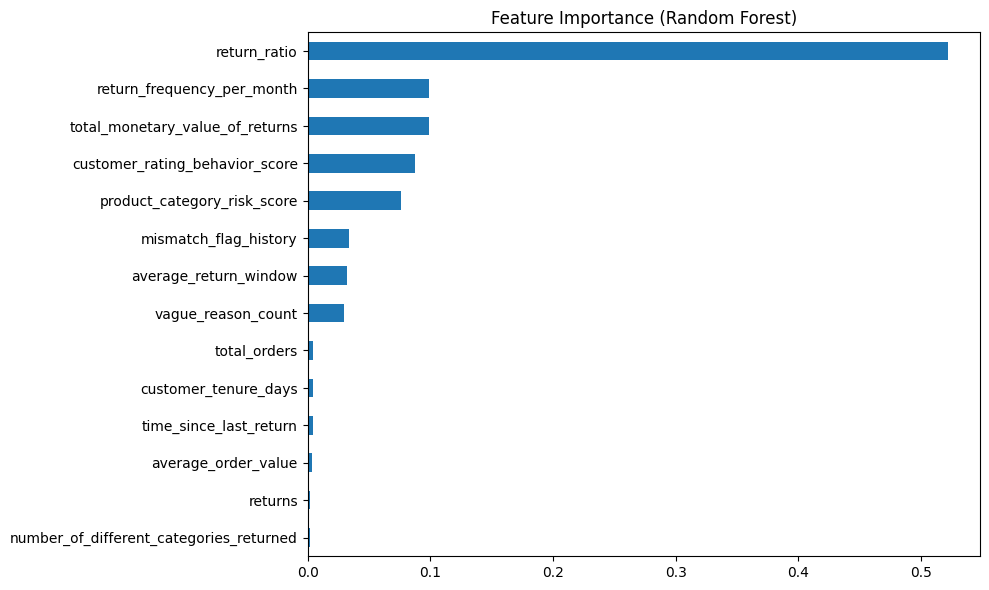

In [16]:
rf_model = results["RandomForest"]["model"].named_steps['model']
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

plt.figure(figsize=(10,6))
feature_importance.sort_values().plot(kind='barh', title="Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()

In [18]:
best_model_name = results_df.sort_values("rmse").index[0]
best_model = results[best_model_name]["model"]
model_path = f"model/return_risk_model_{best_model_name}.pkl"
joblib.dump(best_model, model_path)
print(f"\nBest model '{best_model_name}' saved to: {model_path}")


Best model 'XGBoost' saved to: model/return_risk_model_XGBoost.pkl
